# Literally no reason to use a Neural Network with this data, honestly it's probably detrimental to do so, but I needed to test something out.

## Import Data ##

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import *
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [3]:
files = os.listdir()
data = [f for f in files if f.endswith(".csv")]

if data:
    df = pd.read_csv(data[0])
else:
    print("No data files found in the directory.")

df

,Country,Year,Industry,AI Adoption Rate (%),AI-Generated Content Volume (TBs per year),Job Loss Due to AI (%),Revenue Increase Due to AI (%),Human-AI Collaboration Rate (%),Top AI Tools Used,Regulation Status,Consumer Trust in AI (%),Market Share of AI Companies (%)
0,South Korea,2022,Media,44.29,33.09,16.77,46.12,74.79,Bard,Strict,40.77,18.73
1,China,2025,Legal,34.75,66.74,46.89,52.46,26.17,DALL-E,Strict,35.67,35.02
2,USA,2022,Automotive,81.06,96.13,10.66,45.60,39.66,Stable Diffusion,Moderate,54.47,22.76
3,France,2021,Legal,85.24,93.76,27.70,78.24,29.45,Claude,Moderate,51.84,1.93
4,France,2021,Gaming,78.95,45.62,17.45,1.05,21.70,Midjourney,Strict,41.77,21.41
...,...,...,...,...,...,...,...,...,...,...,...,...
195,Germany,2021,Automotive,89.44,52.98,48.47,12.14,30.60,DALL-E,Lenient,77.21,44.35
196,Germany,2020,Media,70.11,28.26,27.62,57.86,58.71,DALL-E,Strict,78.74,31.73
197,France,2023,Marketing,65.77,49.83,39.94,79.44,43.73,Synthesia,Lenient,81.58,14.62
198,Australia,2023,Automotive,45.35,20.49,33.21,50.50,41.73,Claude,Strict,47.42,43.11


In [5]:
from sklearn.preprocessing import LabelEncoder

#Words to numbers
le = LabelEncoder()
for column in df.columns:
    if df[column].dtype == "object":
        df[column] = le.fit_transform(df[column])

In [7]:
#Standardize data, helpful for linear regression and Neural Networks

copy_df = df.copy()

for column in copy_df.columns:
    copy_df[column] = copy_df[column]/copy_df[column].abs().max()
copy_df

,Country,Year,Industry,AI Adoption Rate (%),AI-Generated Content Volume (TBs per year),Job Loss Due to AI (%),Revenue Increase Due to AI (%),Human-AI Collaboration Rate (%),Top AI Tools Used,Regulation Status,Consumer Trust in AI (%),Market Share of AI Companies (%)
0,0.777778,0.998519,0.888889,0.467391,0.334040,0.337357,0.579761,0.847095,0.000000,1.0,0.453605,0.380073
1,0.222222,1.000000,0.555556,0.366716,0.673733,0.943271,0.659459,0.296410,0.500000,1.0,0.396862,0.710633
2,1.000000,0.998519,0.000000,0.855424,0.970422,0.214444,0.573224,0.449201,0.833333,0.5,0.606030,0.461851
3,0.333333,0.998025,0.555556,0.899536,0.946497,0.557232,0.983532,0.333560,0.333333,0.5,0.576769,0.039164
4,0.333333,0.998025,0.333333,0.833157,0.460529,0.351036,0.013199,0.245781,0.666667,1.0,0.464731,0.434456
...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.444444,0.998025,0.000000,0.943858,0.534827,0.975055,0.152608,0.346585,0.500000,0.0,0.859034,0.899959
196,0.444444,0.997531,0.888889,0.739869,0.285282,0.555623,0.727341,0.664968,0.500000,1.0,0.876057,0.643872
197,0.333333,0.999012,0.777778,0.694069,0.503028,0.803460,0.998617,0.495300,1.000000,0.0,0.907655,0.296672
198,0.000000,0.999012,0.000000,0.478577,0.206844,0.668075,0.634821,0.472647,0.333333,1.0,0.527592,0.874797


In [9]:
def drop():
    global X
    global y
    
    X = copy_df.drop(columns=["Regulation Status"])
    y = copy_df["Regulation Status"]

drop()
copy_df

,Country,Year,Industry,AI Adoption Rate (%),AI-Generated Content Volume (TBs per year),Job Loss Due to AI (%),Revenue Increase Due to AI (%),Human-AI Collaboration Rate (%),Top AI Tools Used,Regulation Status,Consumer Trust in AI (%),Market Share of AI Companies (%)
0,0.777778,0.998519,0.888889,0.467391,0.334040,0.337357,0.579761,0.847095,0.000000,1.0,0.453605,0.380073
1,0.222222,1.000000,0.555556,0.366716,0.673733,0.943271,0.659459,0.296410,0.500000,1.0,0.396862,0.710633
2,1.000000,0.998519,0.000000,0.855424,0.970422,0.214444,0.573224,0.449201,0.833333,0.5,0.606030,0.461851
3,0.333333,0.998025,0.555556,0.899536,0.946497,0.557232,0.983532,0.333560,0.333333,0.5,0.576769,0.039164
4,0.333333,0.998025,0.333333,0.833157,0.460529,0.351036,0.013199,0.245781,0.666667,1.0,0.464731,0.434456
...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.444444,0.998025,0.000000,0.943858,0.534827,0.975055,0.152608,0.346585,0.500000,0.0,0.859034,0.899959
196,0.444444,0.997531,0.888889,0.739869,0.285282,0.555623,0.727341,0.664968,0.500000,1.0,0.876057,0.643872
197,0.333333,0.999012,0.777778,0.694069,0.503028,0.803460,0.998617,0.495300,1.000000,0.0,0.907655,0.296672
198,0.000000,0.999012,0.000000,0.478577,0.206844,0.668075,0.634821,0.472647,0.333333,1.0,0.527592,0.874797


## Data Clean Up ##

In [11]:
stats.zscore(copy_df) #Find outliers

,Country,Year,Industry,AI Adoption Rate (%),AI-Generated Content Volume (TBs per year),Job Loss Due to AI (%),Revenue Increase Due to AI (%),Human-AI Collaboration Rate (%),Top AI Tools Used,Regulation Status,Consumer Trust in AI (%),Market Share of AI Companies (%)
0,0.832723,-0.172989,1.103465,-0.412951,-0.446318,-0.650371,0.269271,1.077554,-1.562919,1.282805,-1.079811,-0.560423
1,-0.973618,1.474524,0.073793,-0.807861,0.710507,1.521800,0.535995,-1.454883,0.005227,1.282805,-1.375013,0.604094
2,1.555259,-0.172989,-1.642326,1.109147,1.720882,-1.091008,0.247395,-0.752238,1.050658,0.012701,-0.286818,-0.272332
3,-0.612349,-0.722160,0.073793,1.282178,1.639406,0.137870,1.620560,-1.284040,-0.517488,0.012701,-0.439049,-1.761399
4,-0.612349,-0.722160,-0.612655,1.021803,-0.015560,-0.601332,-1.626824,-1.687709,0.527943,1.282805,-1.021928,-0.368839
...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.251081,-0.722160,-1.642326,1.456038,0.237464,1.635745,-1.160268,-1.224140,0.005227,-1.257403,1.029435,1.271065
196,-0.251081,-1.271331,1.103465,0.655870,-0.612365,0.132101,0.763173,0.240006,0.005227,1.282805,1.117996,0.368903
197,-0.612349,0.376182,0.760241,0.476215,0.129173,1.020585,1.671044,-0.540247,1.573374,-1.257403,1.282383,-0.854233
198,-1.696154,0.376182,-1.642326,-0.369073,-0.879483,0.535236,0.453538,-0.644420,-0.517488,1.282805,-0.694891,1.182421


In [13]:
#Drop outliers
z = np.abs(stats.zscore(copy_df))
threshold_z = 3
outliers = np.where(z > threshold_z)[0]
copy_df = copy_df.drop(outliers)
drop()
copy_df.shape

(200, 12)

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

                                       feature        VIF
0                                      Country   4.040440
1                                         Year  50.088046
2                                     Industry   3.913290
3                         AI Adoption Rate (%)   6.278057
4   AI-Generated Content Volume (TBs per year)   3.580907
5                       Job Loss Due to AI (%)   4.811302
6               Revenue Increase Due to AI (%)   3.935767
7              Human-AI Collaboration Rate (%)   9.079086
8                            Top AI Tools Used   3.539733
9                     Consumer Trust in AI (%)  13.561761
10            Market Share of AI Companies (%)   4.716702


In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

copy_df = copy_df.copy()

copy_df["pca"] = pca.fit_transform(copy_df[["Year", "Consumer Trust in AI (%)"]])

copy_df = copy_df.drop(["Year", "Consumer Trust in AI (%)"], axis=1)
drop()
copy_df

,Country,Industry,AI Adoption Rate (%),AI-Generated Content Volume (TBs per year),Job Loss Due to AI (%),Revenue Increase Due to AI (%),Human-AI Collaboration Rate (%),Top AI Tools Used,Regulation Status,Market Share of AI Companies (%),pca
0,0.777778,0.888889,0.467391,0.334040,0.337357,0.579761,0.847095,0.000000,1.0,0.380073,-0.207556
1,0.222222,0.555556,0.366716,0.673733,0.943271,0.659459,0.296410,0.500000,1.0,0.710633,-0.264299
2,1.000000,0.000000,0.855424,0.970422,0.214444,0.573224,0.449201,0.833333,0.5,0.461851,-0.055131
3,0.333333,0.555556,0.899536,0.946497,0.557232,0.983532,0.333560,0.333333,0.5,0.039164,-0.084392
4,0.333333,0.333333,0.833157,0.460529,0.351036,0.013199,0.245781,0.666667,1.0,0.434456,-0.196430
...,...,...,...,...,...,...,...,...,...,...,...
195,0.444444,0.000000,0.943858,0.534827,0.975055,0.152608,0.346585,0.500000,0.0,0.899959,0.197873
196,0.444444,0.888889,0.739869,0.285282,0.555623,0.727341,0.664968,0.500000,1.0,0.643872,0.214896
197,0.333333,0.777778,0.694069,0.503028,0.803460,0.998617,0.495300,1.000000,0.0,0.296672,0.246494
198,0.000000,0.000000,0.478577,0.206844,0.668075,0.634821,0.472647,0.333333,1.0,0.874797,-0.133569


In [19]:
copy_df.isna().sum()

Country                                       0
Industry                                      0
AI Adoption Rate (%)                          0
AI-Generated Content Volume (TBs per year)    0
Job Loss Due to AI (%)                        0
Revenue Increase Due to AI (%)                0
Human-AI Collaboration Rate (%)               0
Top AI Tools Used                             0
Regulation Status                             0
Market Share of AI Companies (%)              0
pca                                           0
dtype: int64

In [ ]:
copy_df = copy_df.dropna().reset_index(drop=True) #drop rows with missing values

In [21]:
copy_df.duplicated().sum()

0

In [ ]:
copy_df = copy_df.drop_duplicates().reset_index(drop=True) #drop duplicate rows

In [23]:
drop()
copy_df

,Country,Industry,AI Adoption Rate (%),AI-Generated Content Volume (TBs per year),Job Loss Due to AI (%),Revenue Increase Due to AI (%),Human-AI Collaboration Rate (%),Top AI Tools Used,Regulation Status,Market Share of AI Companies (%),pca
0,0.777778,0.888889,0.467391,0.334040,0.337357,0.579761,0.847095,0.000000,1.0,0.380073,-0.207556
1,0.222222,0.555556,0.366716,0.673733,0.943271,0.659459,0.296410,0.500000,1.0,0.710633,-0.264299
2,1.000000,0.000000,0.855424,0.970422,0.214444,0.573224,0.449201,0.833333,0.5,0.461851,-0.055131
3,0.333333,0.555556,0.899536,0.946497,0.557232,0.983532,0.333560,0.333333,0.5,0.039164,-0.084392
4,0.333333,0.333333,0.833157,0.460529,0.351036,0.013199,0.245781,0.666667,1.0,0.434456,-0.196430
...,...,...,...,...,...,...,...,...,...,...,...
195,0.444444,0.000000,0.943858,0.534827,0.975055,0.152608,0.346585,0.500000,0.0,0.899959,0.197873
196,0.444444,0.888889,0.739869,0.285282,0.555623,0.727341,0.664968,0.500000,1.0,0.643872,0.214896
197,0.333333,0.777778,0.694069,0.503028,0.803460,0.998617,0.495300,1.000000,0.0,0.296672,0.246494
198,0.000000,0.000000,0.478577,0.206844,0.668075,0.634821,0.472647,0.333333,1.0,0.874797,-0.133569


## Statistical Modeling ##

Shape:  (200, 12)

Counts:
 Regulation Status
1    76
0    63
2    61
Name: count, dtype: int64



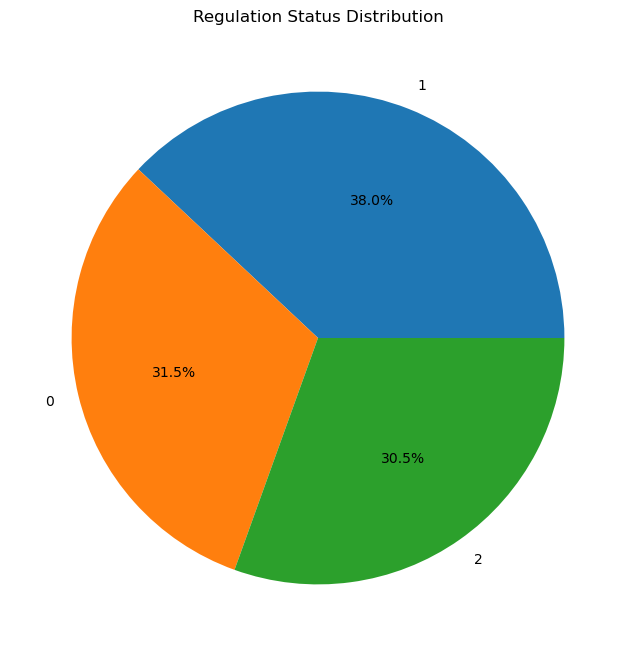

In [25]:
print("Shape: ", df.shape)
print("\nCounts:\n", df["Regulation Status"].value_counts())

print()

plt.figure(figsize=(8,8))
plt.pie(df["Regulation Status"].value_counts(), labels = df["Regulation Status"].value_counts().index, autopct="%1.1f%%")
plt.title("Regulation Status Distribution")
plt.show()

In [27]:
copy_df.describe()

,Country,Industry,AI Adoption Rate (%),AI-Generated Content Volume (TBs per year),Job Loss Due to AI (%),Revenue Increase Due to AI (%),Human-AI Collaboration Rate (%),Top AI Tools Used,Regulation Status,Market Share of AI Companies (%),pca
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,2.000000e+02
mean,0.521667,0.531667,0.572666,0.465098,0.518774,0.499302,0.612778,0.498333,0.495000,0.539155,-4.440892e-17
std,0.308330,0.324540,0.255573,0.294379,0.279644,0.299554,0.217998,0.319648,0.394657,0.284572,1.926977e-01
min,0.000000,0.000000,0.111123,0.010499,0.001811,0.001760,0.228905,0.000000,0.000000,0.023945,-3.260475e-01
25%,0.222222,0.305556,0.350596,0.205153,0.301650,0.225110,0.427795,0.166667,0.000000,0.285156,-1.632192e-01
50%,0.555556,0.555556,0.562579,0.447406,0.517703,0.529227,0.617454,0.500000,0.500000,0.555804,-2.338153e-03
75%,0.777778,0.888889,0.804348,0.722996,0.752716,0.737869,0.786074,0.833333,1.000000,0.779880,1.720055e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.388391e-01


In [29]:
copy_df.corr()

,Country,Industry,AI Adoption Rate (%),AI-Generated Content Volume (TBs per year),Job Loss Due to AI (%),Revenue Increase Due to AI (%),Human-AI Collaboration Rate (%),Top AI Tools Used,Regulation Status,Market Share of AI Companies (%),pca
Country,1.000000,-0.038510,0.023604,-0.081348,-0.059022,-0.083777,0.010710,-0.018516,-0.067932,-0.068690,-0.142025
Industry,-0.038510,1.000000,-0.128140,-0.061900,-0.148856,0.002177,-0.056595,-0.045238,-0.085944,0.021389,0.081611
AI Adoption Rate (%),0.023604,-0.128140,1.000000,-0.042364,-0.004589,0.001883,0.050359,-0.007522,0.048941,0.065829,-0.115227
AI-Generated Content Volume (TBs per year),-0.081348,-0.061900,-0.042364,1.000000,0.062185,0.029310,0.018461,0.061665,-0.039742,-0.027789,0.027773
Job Loss Due to AI (%),-0.059022,-0.148856,-0.004589,0.062185,1.000000,0.152893,0.021559,0.108417,-0.039072,0.078331,0.082446
Revenue Increase Due to AI (%),-0.083777,0.002177,0.001883,0.029310,0.152893,1.000000,0.081275,0.040420,-0.094179,0.006712,0.028598
Human-AI Collaboration Rate (%),0.010710,-0.056595,0.050359,0.018461,0.021559,0.081275,1.000000,0.031250,0.087862,-0.040572,0.003955
Top AI Tools Used,-0.018516,-0.045238,-0.007522,0.061665,0.108417,0.040420,0.031250,1.000000,0.006573,0.050180,-0.080643
Regulation Status,-0.067932,-0.085944,0.048941,-0.039742,-0.039072,-0.094179,0.087862,0.006573,1.000000,0.116717,-0.127427
Market Share of AI Companies (%),-0.068690,0.021389,0.065829,-0.027789,0.078331,0.006712,-0.040572,0.050180,0.116717,1.000000,-0.032108


In [31]:
kstest(X, "norm").pvalue #p-value for each row

array([9.25638541e-47, 9.25638541e-47, 4.72185702e-56, 1.35461686e-47,
       3.87841950e-47, 6.71689618e-47, 5.60302469e-67, 9.25638541e-47,
       1.12094938e-48, 2.24525773e-25])

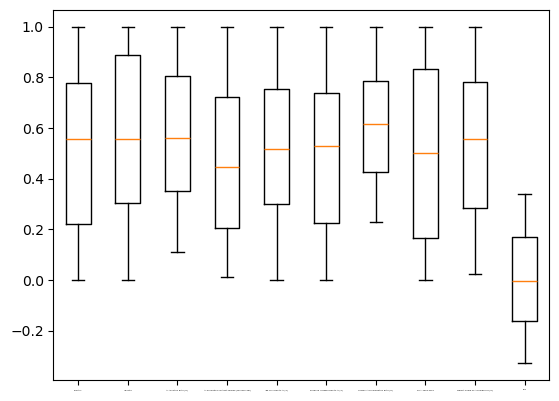

In [37]:
import seaborn as sn

#When dealing with very large data-sets/working with others using graphs to see things would be beneficial to everyone's sanity
fig, ax = plt.subplots()
ax.boxplot(X)
ax.set_xticklabels(X.columns, size=1.5)
plt.show()

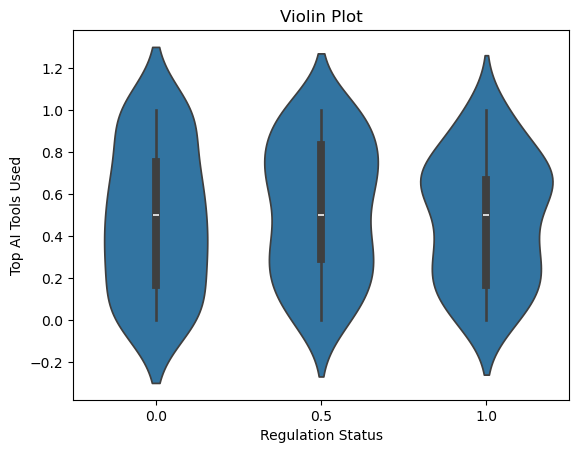

In [39]:
sn.violinplot(x="Regulation Status", y="Top AI Tools Used", data=copy_df)
plt.title("Violin Plot")
plt.show()

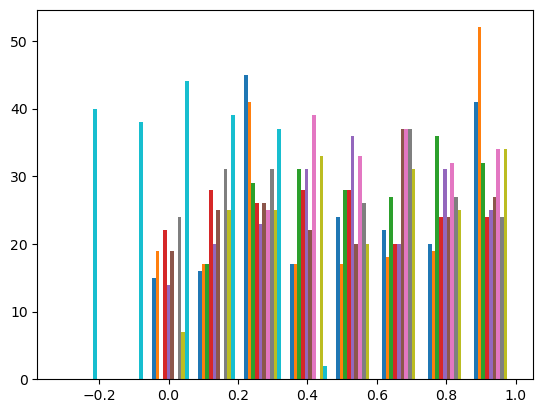

In [41]:
plt.hist(X)
plt.show()

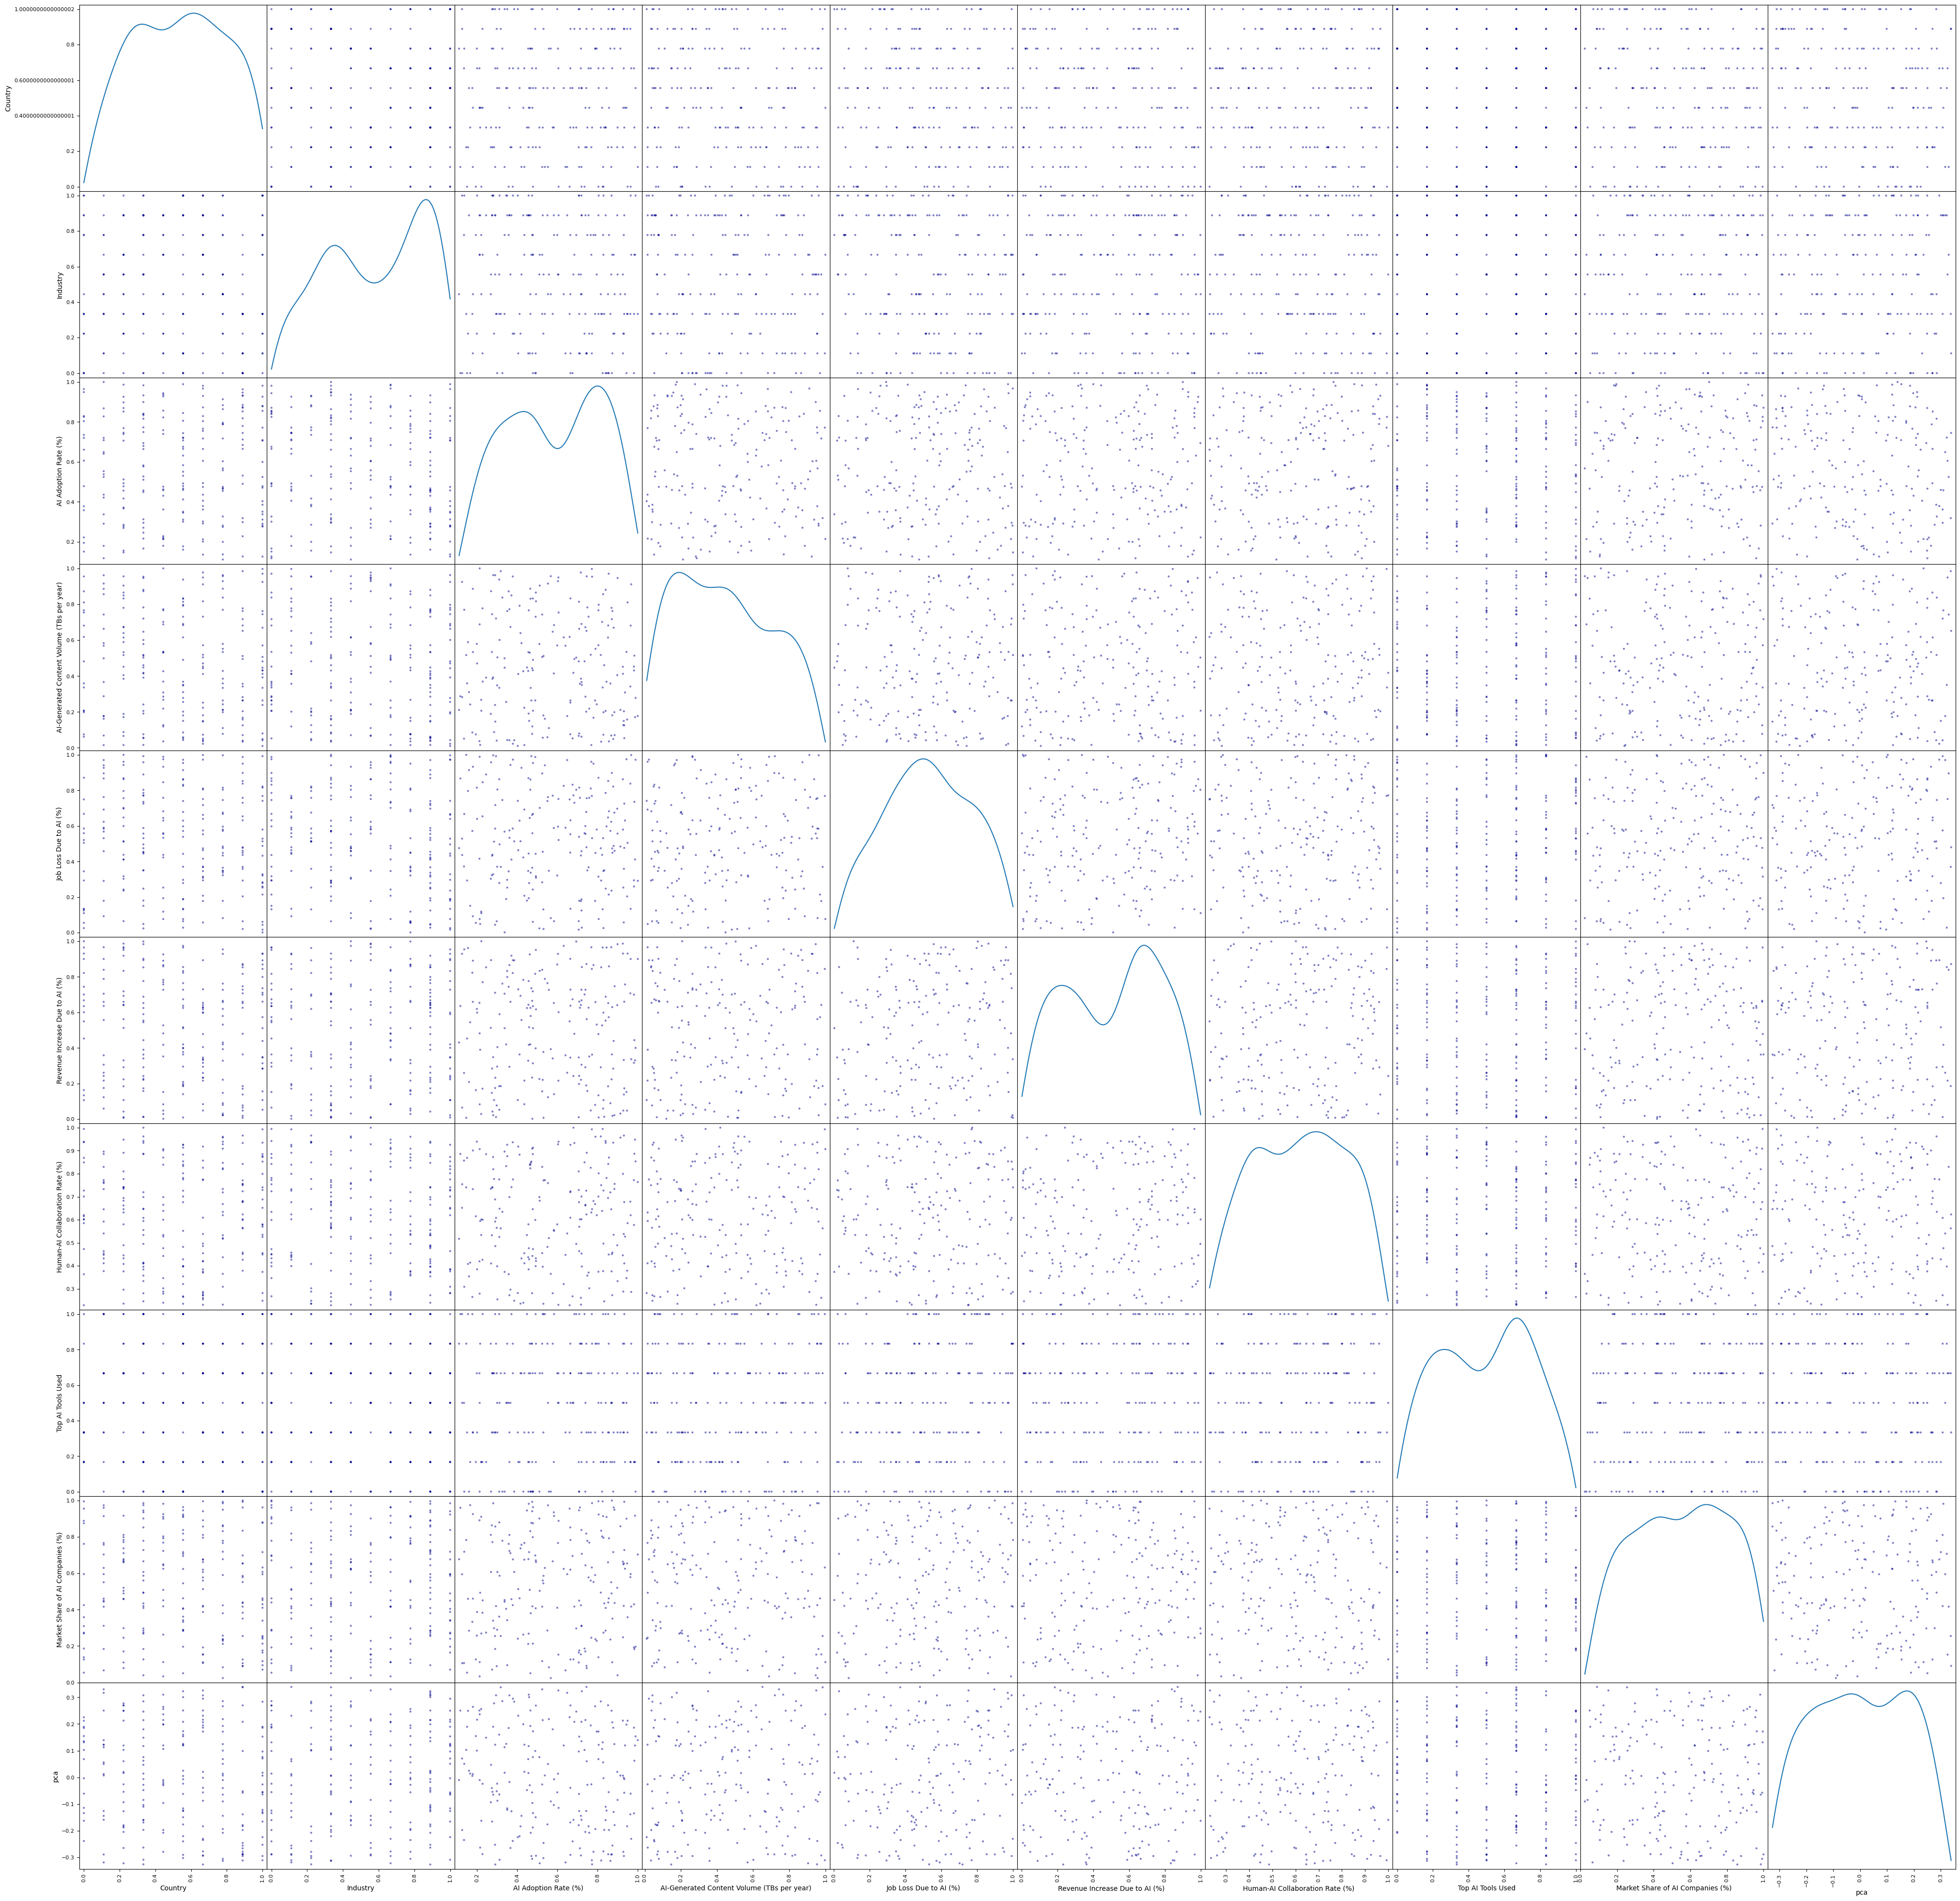

In [43]:
from pandas.plotting import scatter_matrix

scatter_matrix(X, alpha = 0.5, figsize = (50, 50), diagonal = "kde", c="#00008B");

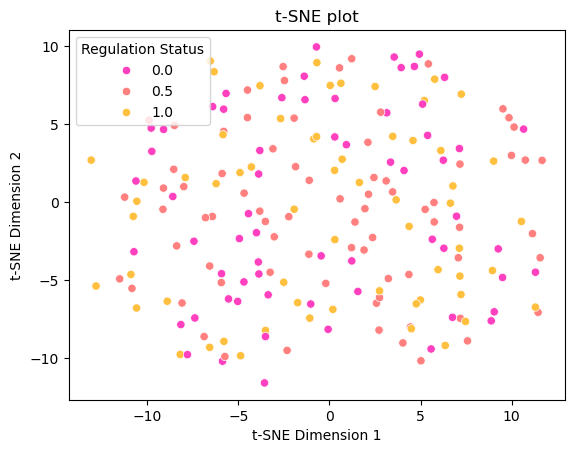

In [45]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state = 42)
X_embedded = tsne.fit_transform(X)

sn.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, palette=sn.color_palette("spring", 3))
plt.title("t-SNE plot")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

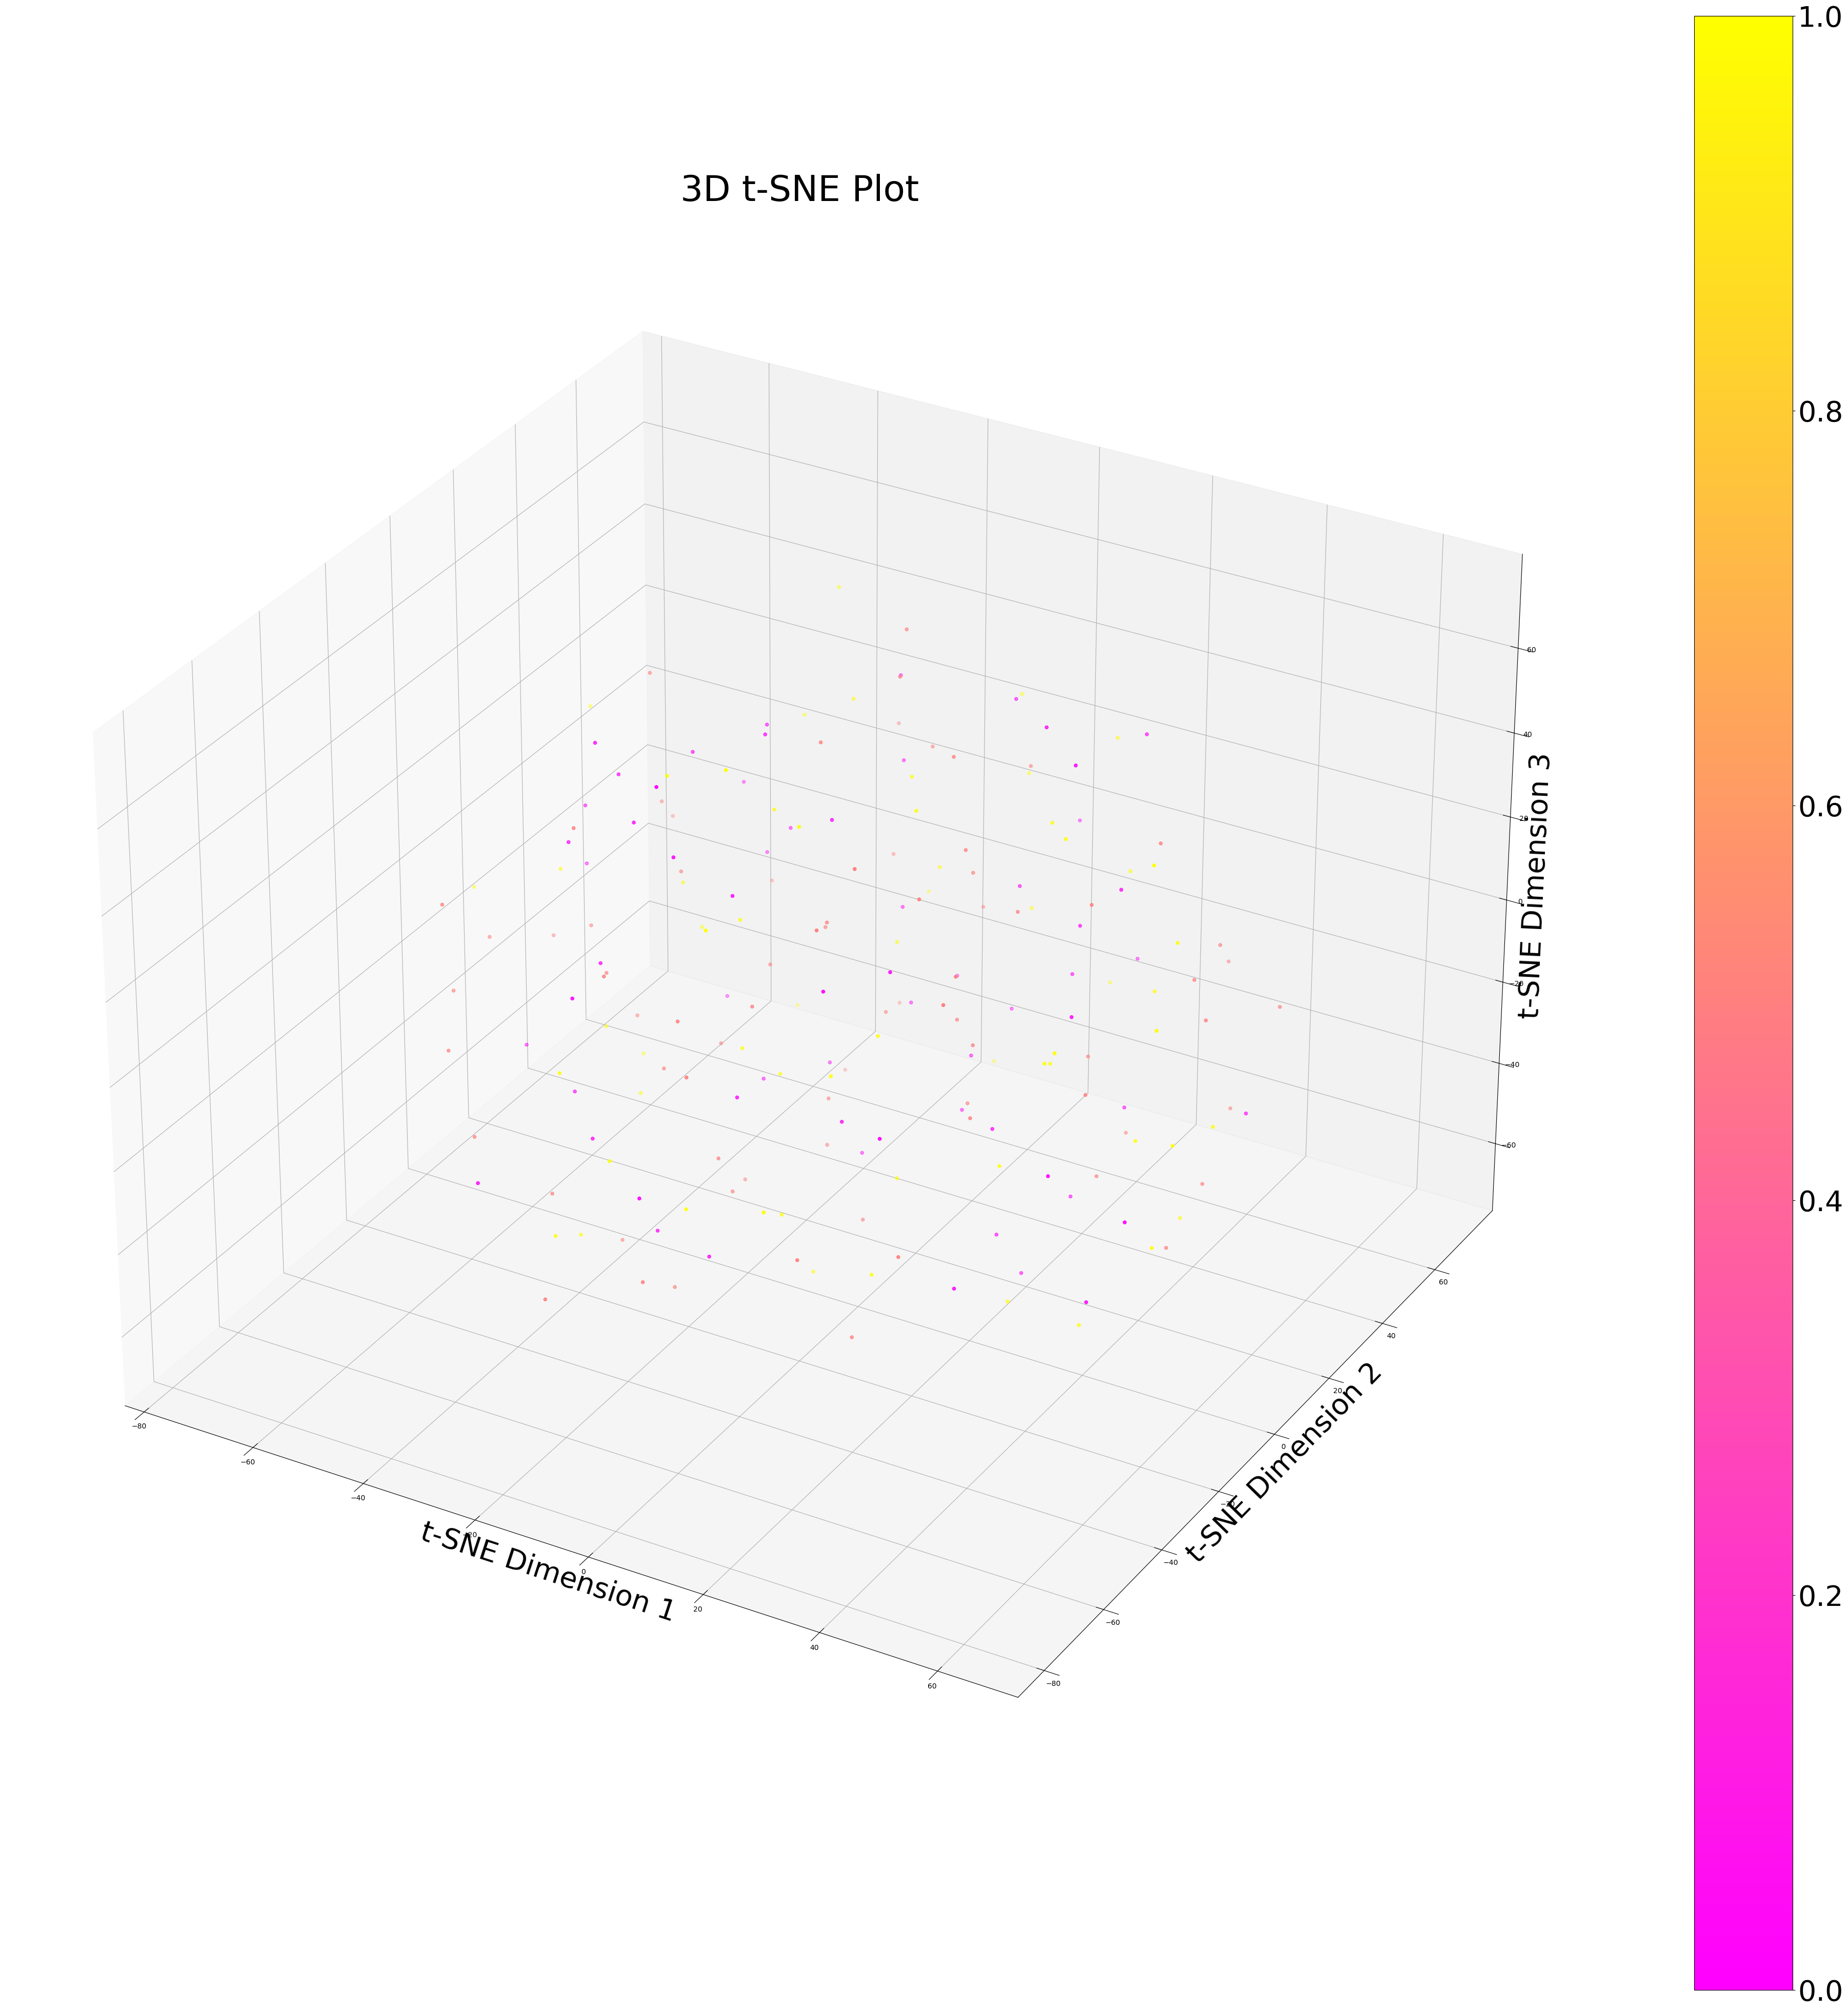

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(X)

fig = plt.figure(figsize = (50, 50))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y, cmap="spring")

ax.set_title("3D t-SNE Plot", fontsize=50)
ax.set_xlabel("t-SNE Dimension 1", fontsize=40)
ax.set_ylabel("t-SNE Dimension 2", fontsize=40)
ax.set_zlabel("t-SNE Dimension 3", fontsize=40)

cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=40)

plt.show()

## Training Model ##

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [51]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [53]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(140, 10)
(30, 10)
(30, 10)


In [55]:
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype = torch.float32).to(device)
        self.y = torch.tensor(np.array(y), dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [57]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [119]:
LR = 1e-4
BATCH_SIZE = 2
EPOCHS = 10

In [121]:
train_dataloader = DataLoader(training_data, batch_size = BATCH_SIZE, shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size = BATCH_SIZE, shuffle = True)
testing_dataloader = DataLoader(testing_data, batch_size = BATCH_SIZE, shuffle = True)

In [265]:
Hidden_Neurons = 20

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], Hidden_Neurons)
        
        self.hidden_layer1 = nn.Linear(X.shape[1], Hidden_Neurons)
        self.hidden_layer2 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        self.hidden_layer3 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        
        self.linear = nn.Linear(Hidden_Neurons, 1) #output layer
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        #Forward Propagation
        x = x.to(device)
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

model = MyModel().to(device)

In [267]:
summary(model)

Layer (type:depth-idx)                   Param #
MyModel                                  --
├─Linear: 1-1                            220
├─Linear: 1-2                            220
├─Linear: 1-3                            420
├─Linear: 1-4                            420
├─Linear: 1-5                            21
├─Sigmoid: 1-6                           --
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0

In [269]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = LR)

In [271]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for data in train_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)
        
        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        #Back Propagation
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)

            batch_loss = criterion(prediction, labels)
        
            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc
        
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/training_data.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1} 
    Training Loss: {round(total_loss_train/1000, 4)} 
    Training Accuracy: {round(total_acc_train/training_data.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/1000, 4)} 
    Validation Accuracy: {round(total_acc_val/validation_data.__len__()*100, 4)}''')

    print("="*50)

Epoch no. 1 
    Training Loss: 0.0499 
    Training Accuracy: 29.2857 
    Validation Loss: 0.0108 
    Validation Accuracy: 33.3333
Epoch no. 2 
    Training Loss: 0.0496 
    Training Accuracy: 29.2857 
    Validation Loss: 0.0108 
    Validation Accuracy: 33.3333
Epoch no. 3 
    Training Loss: 0.0494 
    Training Accuracy: 29.2857 
    Validation Loss: 0.0107 
    Validation Accuracy: 33.3333
Epoch no. 4 
    Training Loss: 0.0492 
    Training Accuracy: 29.2857 
    Validation Loss: 0.0107 
    Validation Accuracy: 33.3333
Epoch no. 5 
    Training Loss: 0.049 
    Training Accuracy: 29.2857 
    Validation Loss: 0.0106 
    Validation Accuracy: 33.3333
Epoch no. 6 
    Training Loss: 0.0489 
    Training Accuracy: 29.2857 
    Validation Loss: 0.0106 
    Validation Accuracy: 33.3333
Epoch no. 7 
    Training Loss: 0.0488 
    Training Accuracy: 29.2857 
    Validation Loss: 0.0106 
    Validation Accuracy: 33.3333
Epoch no. 8 
    Training Loss: 0.0487 
    Training Accuracy: 

In [277]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in testing_dataloader:
        inputs, labels = data
        prediction = model(inputs).squeeze(1)

        batch_loss_test = criterion(prediction, labels).item()
        total_loss_test += batch_loss_test
        
        acc = (prediction.round() == labels).sum().item()
        
        total_acc_test += acc
        total_loss_test += batch_loss_test

print(f'''Accuracy Score: {round(total_acc_test/testing_data.__len__()*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 100.0 
Loss: 0.019


## Post-Training Analysis ##

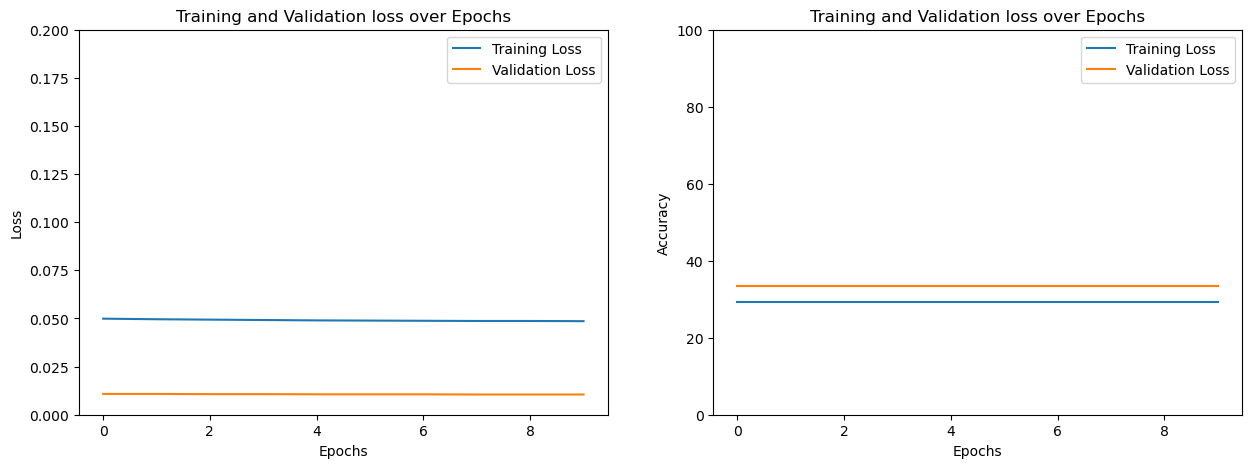

In [279]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,0.2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [281]:
torch.save(model.state_dict(), "Regulation.pth")

In [283]:
loaded_model = MyModel().to(device)
loaded_model.load_state_dict(torch.load("Regulation.pth"))
loaded_model.eval()

MyModel(
  (input_layer): Linear(in_features=10, out_features=20, bias=True)
  (hidden_layer1): Linear(in_features=10, out_features=20, bias=True)
  (hidden_layer2): Linear(in_features=20, out_features=20, bias=True)
  (hidden_layer3): Linear(in_features=20, out_features=20, bias=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)